# Generating Adversarial Images Using Logistic Regression

In this project, the *mnist* data set was used to train the logistic regression model. The model was then used to generate adversarial images so that these new images could be then used to make any prediction when these images were fed back into the model.

## Training the Model

The *mnist* data set was fed into a logistic regression model that classified each image.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Start an interactive session
sess = tf.InteractiveSession()

# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# set model weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Initialize all tf variables
sess.run(tf.global_variables_initializer())

# construct model
logits = tf.matmul(x, W) + b
pred = tf.nn.softmax(logits)  # Softmax
    
# minimize error using cross entropy
cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred), reduction_indices=1))
    
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(cost)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# training cycle
for epoch in range(25):

    avg_cost = 0
    total_batch = int(mnist.train.num_examples/100)

    # loop over all batches
    for i in range(total_batch):

        batch_xs, batch_ys = mnist.train.next_batch(100)

        # Assign the contents of `batch_xs` to variable `x`.
        _, c = sess.run([optimizer, cost], feed_dict={x:batch_xs, y: batch_ys})
                
        # compute average loss
        avg_cost += c / total_batch

    # display logs per epoch step
    if (epoch + 1) % 1 == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

Epoch: 0001 cost= 0.674963187
Epoch: 0002 cost= 0.416469806
Epoch: 0003 cost= 0.374567720
Epoch: 0004 cost= 0.353339317
Epoch: 0005 cost= 0.339585618
Epoch: 0006 cost= 0.329813870
Epoch: 0007 cost= 0.322344816
Epoch: 0008 cost= 0.316454108
Epoch: 0009 cost= 0.311632368
Epoch: 0010 cost= 0.307519910
Epoch: 0011 cost= 0.304058294
Epoch: 0012 cost= 0.300870477
Epoch: 0013 cost= 0.298260636
Epoch: 0014 cost= 0.295719318
Epoch: 0015 cost= 0.293550973
Epoch: 0016 cost= 0.291624172
Epoch: 0017 cost= 0.289792292
Epoch: 0018 cost= 0.288065800
Epoch: 0019 cost= 0.286555504
Epoch: 0020 cost= 0.285256007
Epoch: 0021 cost= 0.283751013
Epoch: 0022 cost= 0.282676184
Epoch: 0023 cost= 0.281513178
Epoch: 0024 cost= 0.280468754
Epoch: 0025 cost= 0.279452844


In [4]:
# list of booleans to determine the correct predictions
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
print(correct_prediction.eval({x:mnist.test.images, y:mnist.test.labels}))

[ True  True  True ...,  True  True  True]


In [5]:
# calculate total accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

Accuracy: 0.9229


The model has a 92% accuracy at predicting the correct image which is not the most ideal. A higher accuracy can be achieved by changing some values around however for the sake of convenience the current accuracy is accepted.

## Finding the Optimal Epsilon Values 

The weights of the **Softmax** model become useful in this step. 10 images of the number 2 are extracted and the gradient is calculated for each image based on the previously trained **Softmax** model. A fake label of 6 is assigned to each image so that the gradient calculation will yield the amount necessary to change the prediction of a number 2 to a number 6.

In [6]:
# initialize array that will store images of number 2
labels_of_2 = []
        
# get number 2 from mnist dataset
while mnist.test.next_batch(1):

    # get next batch
    sample_image, sample_label = mnist.test.next_batch(1)

    # returns index of label
    itemindex = np.where(sample_label == 1)

    # if image label is a number 2 store the image
    if itemindex[1][0] == 2:
        labels_of_2.append(sample_image)
    else:
        continue

    # if there are 10 images stored then end the loop
    if len(labels_of_2) == 10:
        break

# convert into a numpy array of shape [10, 784]
adversarial = np.concatenate(labels_of_2, axis=0)

In [7]:
# generate 101 different epsilon values to test with
epsilon_res = 101
eps = np.linspace(-1.0, 1.0, epsilon_res).reshape((epsilon_res, 1))
    
# labels for each image (used for graphing)
labels = [str(i) for i in range(10)]

# set different colors for every Softmax hypothesis
num_colors = 10
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
        
# Create an empty array for our scores
scores = np.zeros((len(eps), 10))

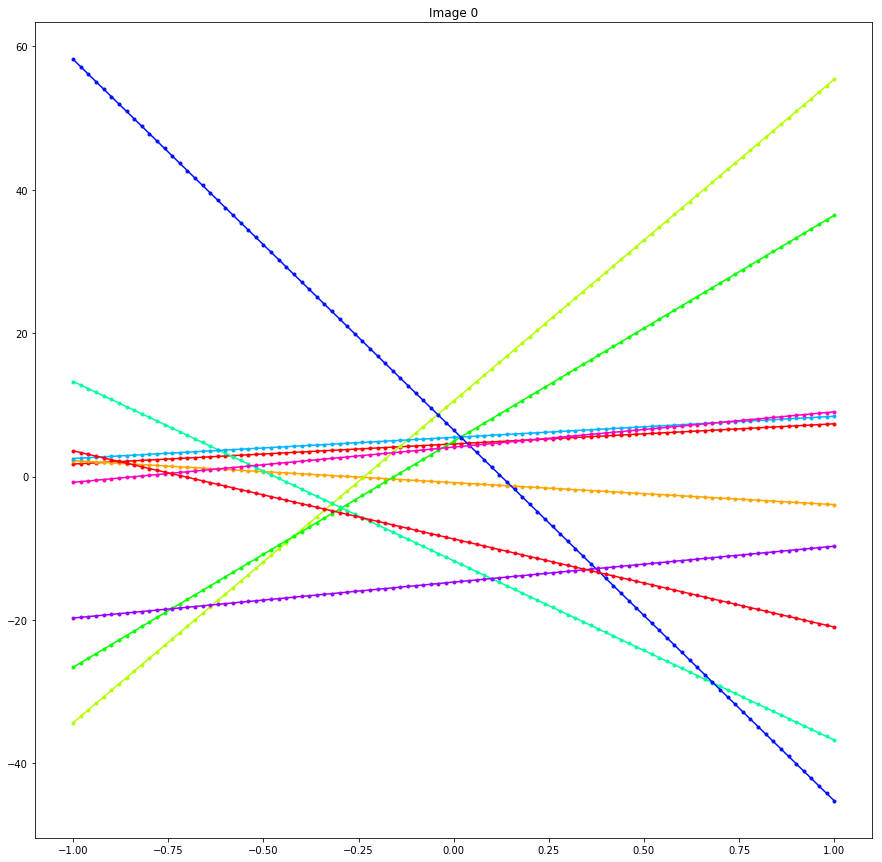

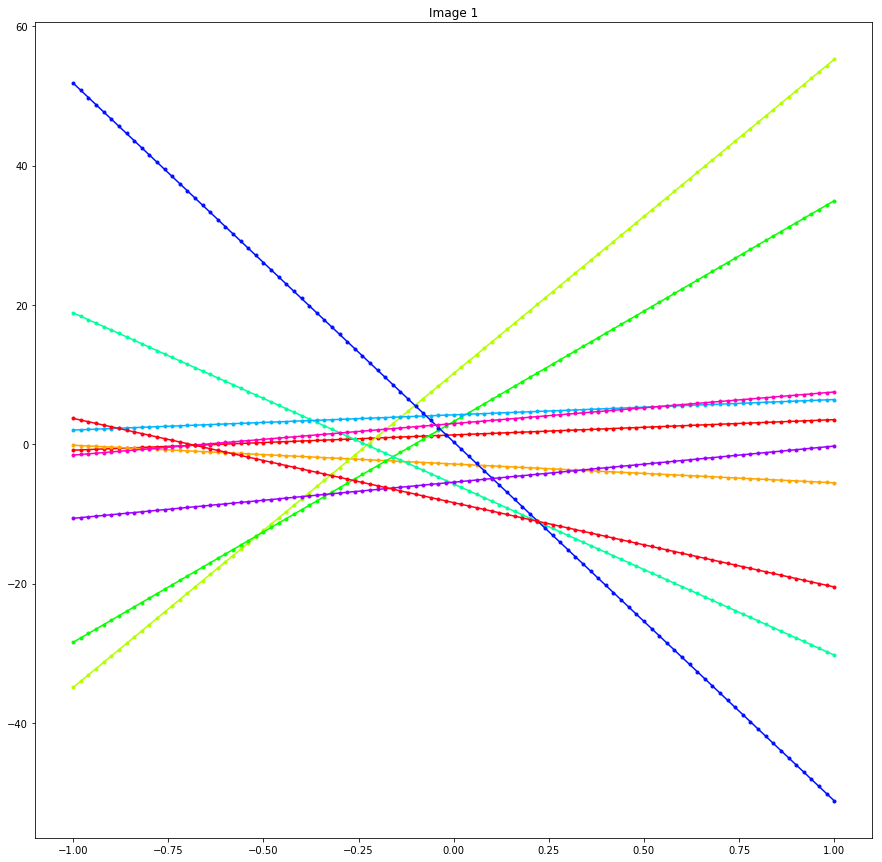

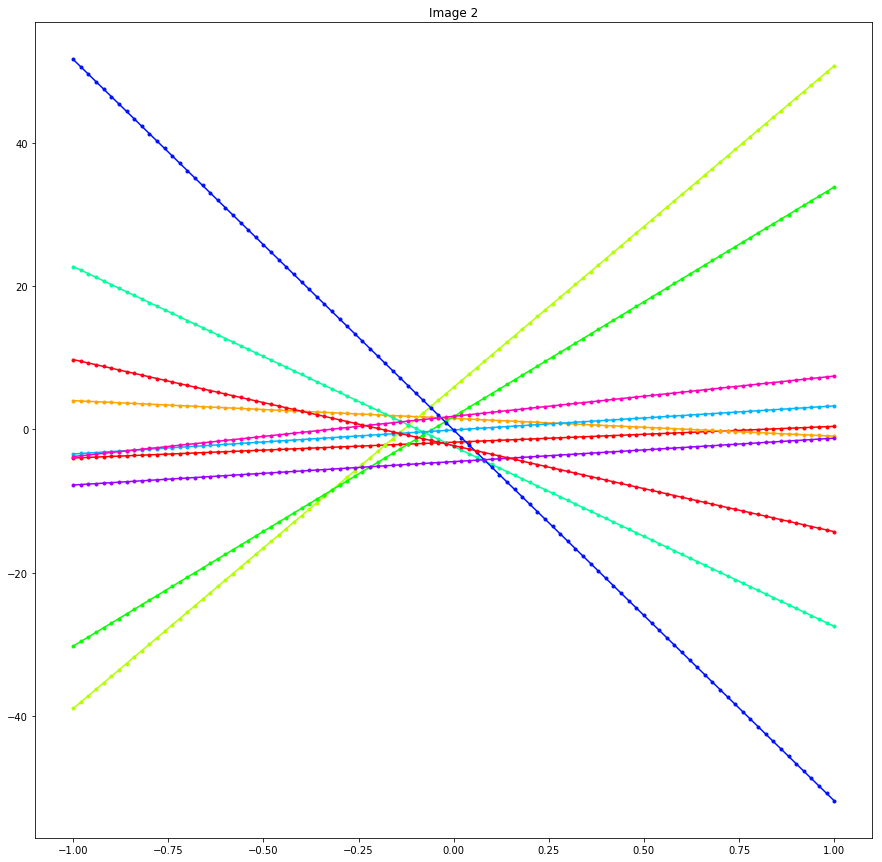

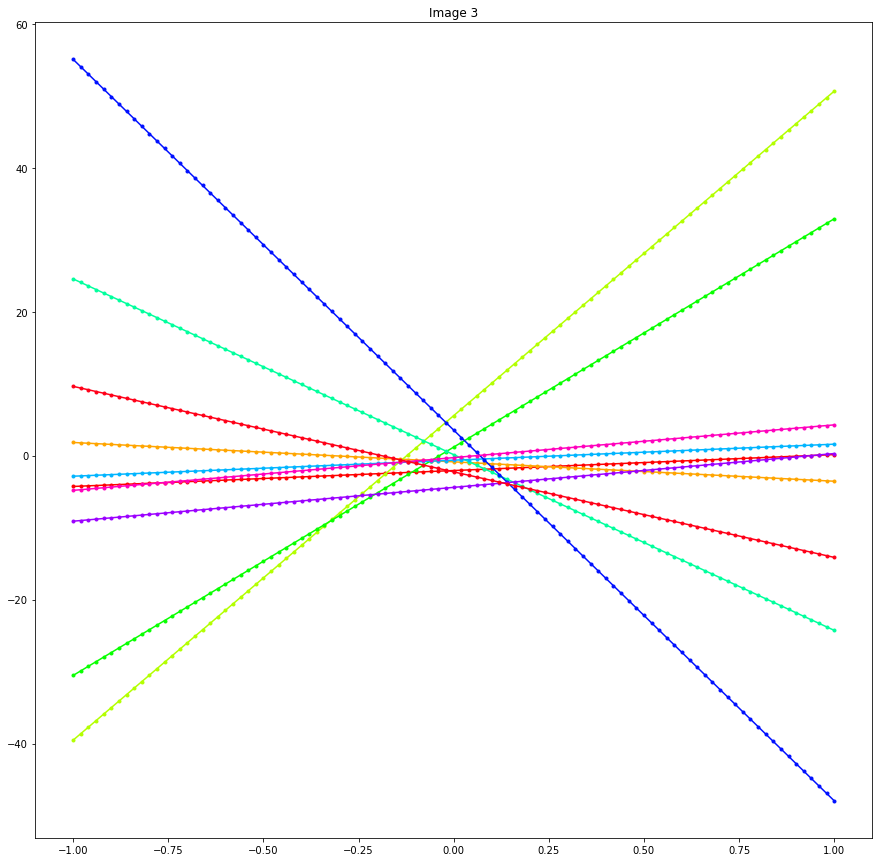

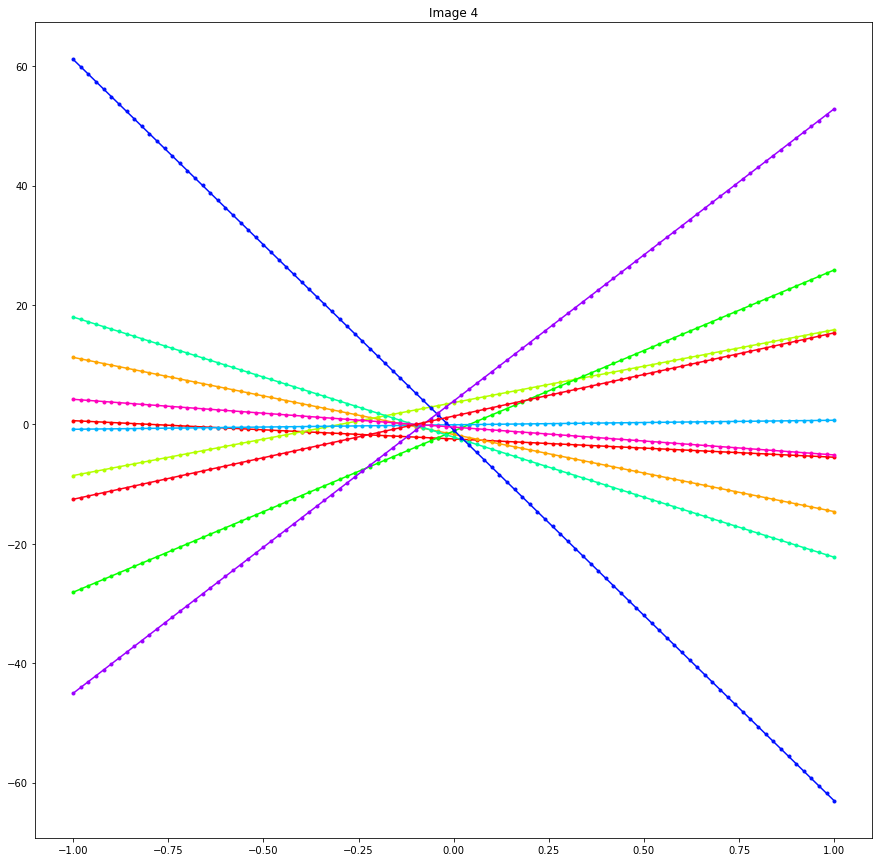

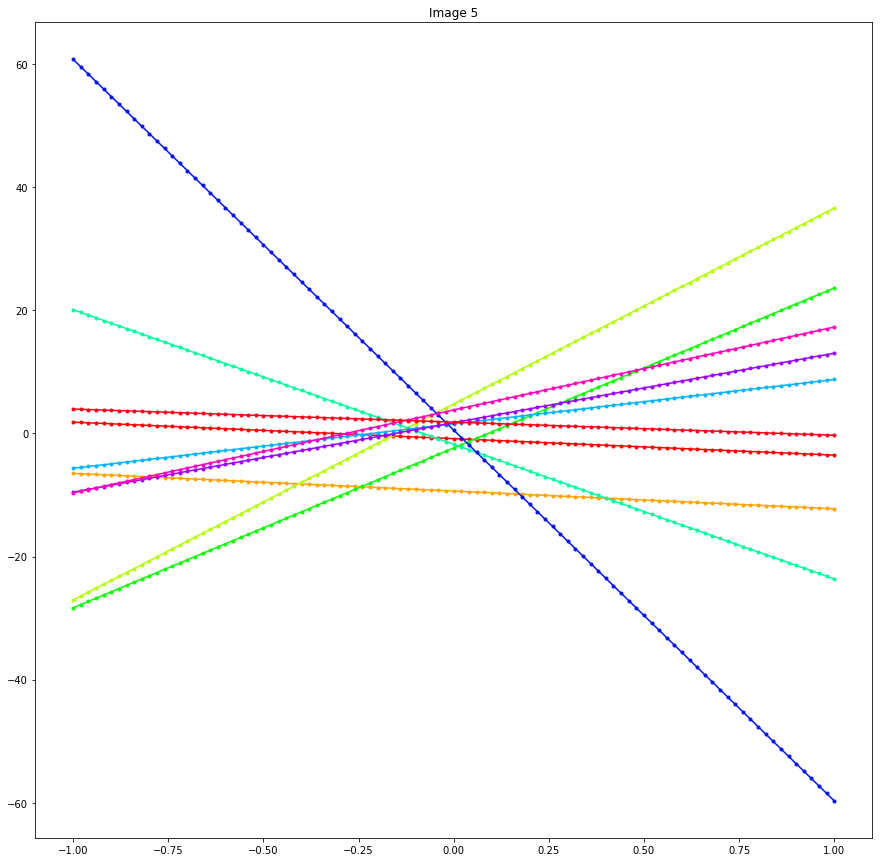

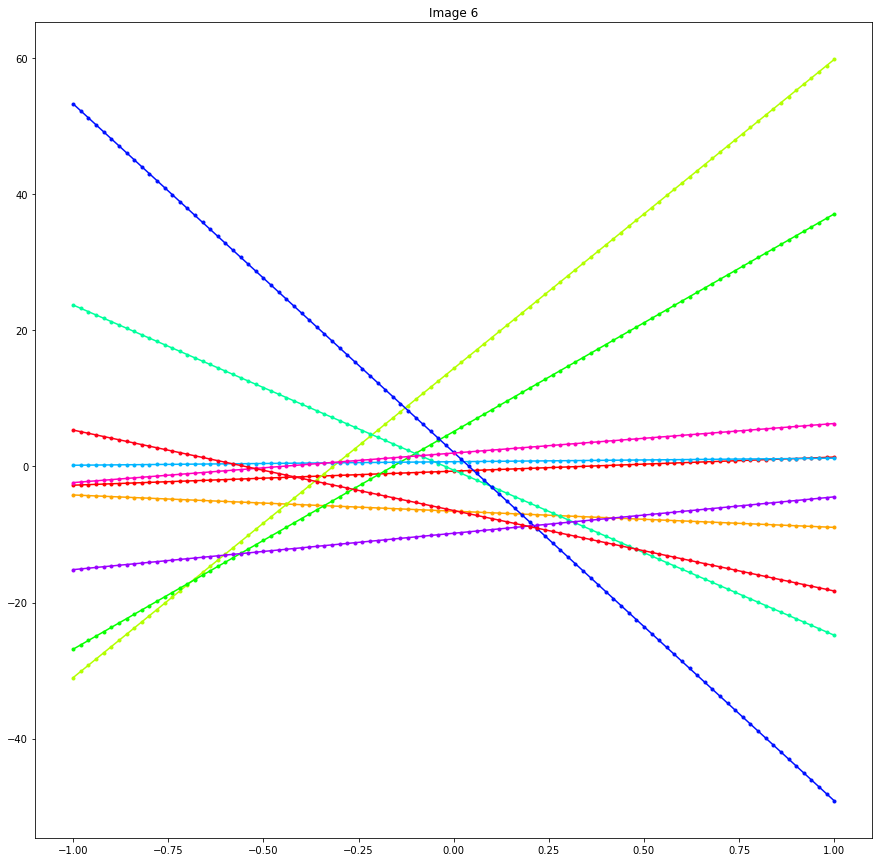

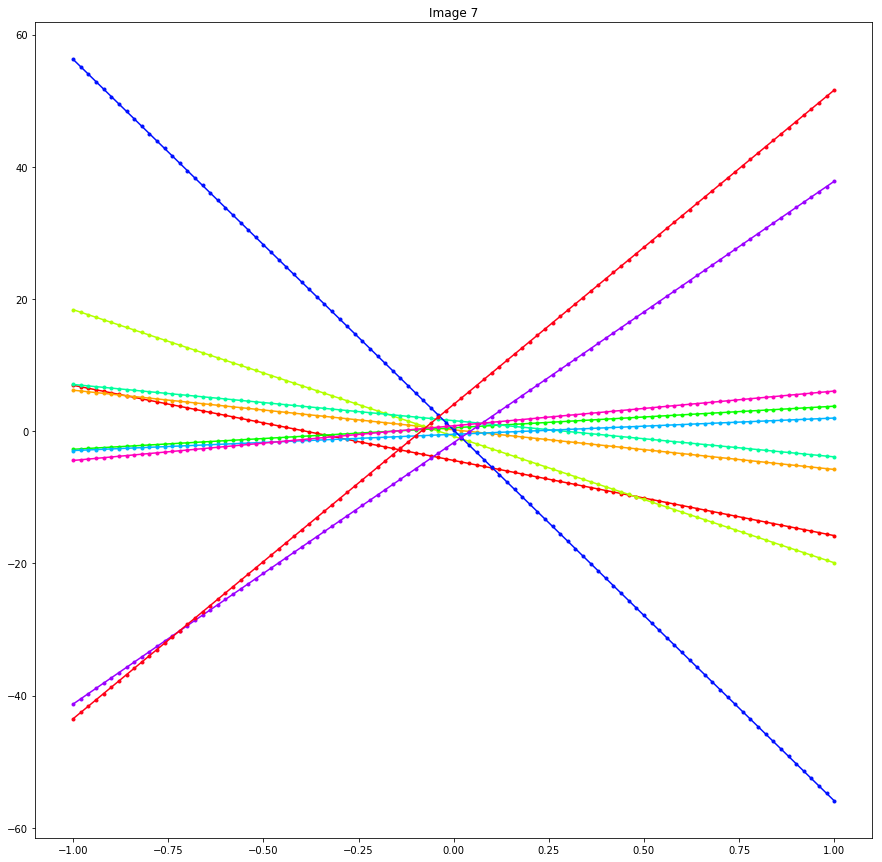

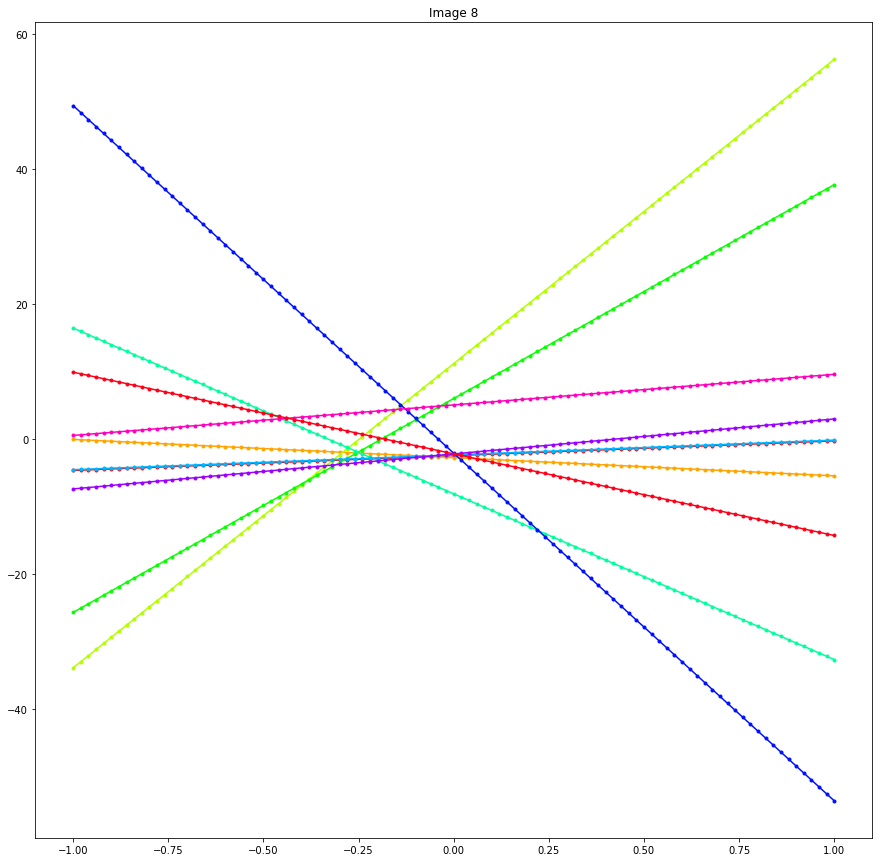

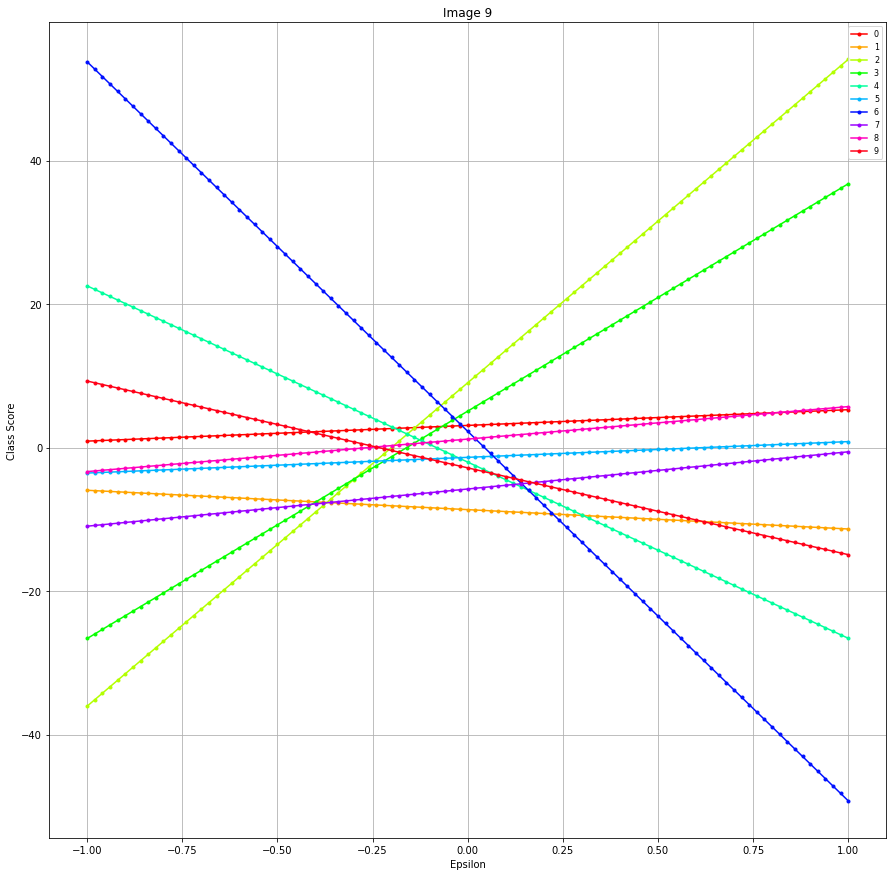

In [8]:
# placeholder for target label
fake_label = tf.placeholder(tf.int32, shape=[10])

# setup the fake loss
fake_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=fake_label)

# calculate gradient
gradients = tf.gradients(fake_loss, x)

# compute gradient value using the same Softmax model used to train the orginal model,
# the gradient generates the values necessary to change the predictions of the number 2 to a number 6
# with minimal cost
gradient_value = sess.run(gradients, feed_dict={x:adversarial, fake_label:np.array([6]*10)})

for j in range(len(adversarial)):

    # extract the sign of the gradient value for each image
    sign = np.sign(gradient_value[0][j])

    # apply every epsilon value along with the sign of the gradient to the image
    for i in range(len(eps)):
        x_fool = adversarial[j].reshape((1, 784)) + eps[i] * sign

        # the scores are re-evaluated using the model and each 10 hypotheses are saved
        scores[i, :] = logits.eval({x:x_fool})

    # create a figure
    plt.figure(figsize=(15, 15))
    plt.title("Image {}".format(j))

    # loop through transpose of the scores to plot the effect of epsilon of every hypothesis
    for k in range(len(scores.T)):
        plt.plot(eps, scores[:, k], 
                     color=colors[k], 
                     marker='.', 
                     label=labels[k])
 
plt.legend(prop={'size':8})
plt.xlabel('Epsilon')
plt.ylabel('Class Score')
plt.grid('on')
plt.show()  

As is quite visible, there is a value for epsilon where the blue line (label 6) rises above the rest. The closer the epsilon value is to the rest of the lines, the less the image will be distorted.

## Generating Adversarial Images 

In [9]:
# create a copy to graph the original image and compare its adversarial counterpart
original_copy = np.concatenate(labels_of_2, axis=0)

In [10]:
# these are the optimal epsilon values chosen through analyzing the graphs
# generated by epsilon.py
epsilons = np.array([-0.15, -0.15, -0.15, -0.15, 
                     -0.15, -0.15, -0.2, -0.2, 
                     -0.2, -0.2]).reshape((10, 1))

In [11]:
# array to hold the sign of every gradient
sign_values = []
        
for j in range(len(adversarial)):

    # calculate the sign of the gradient
    sign = np.sign(gradient_value[0][j])

    # save all sign values
    sign_values.append(sign)

    noise = epsilons * sign

    # apply the noise to every image
    adversarial[j] = adversarial[j] + noise[j]

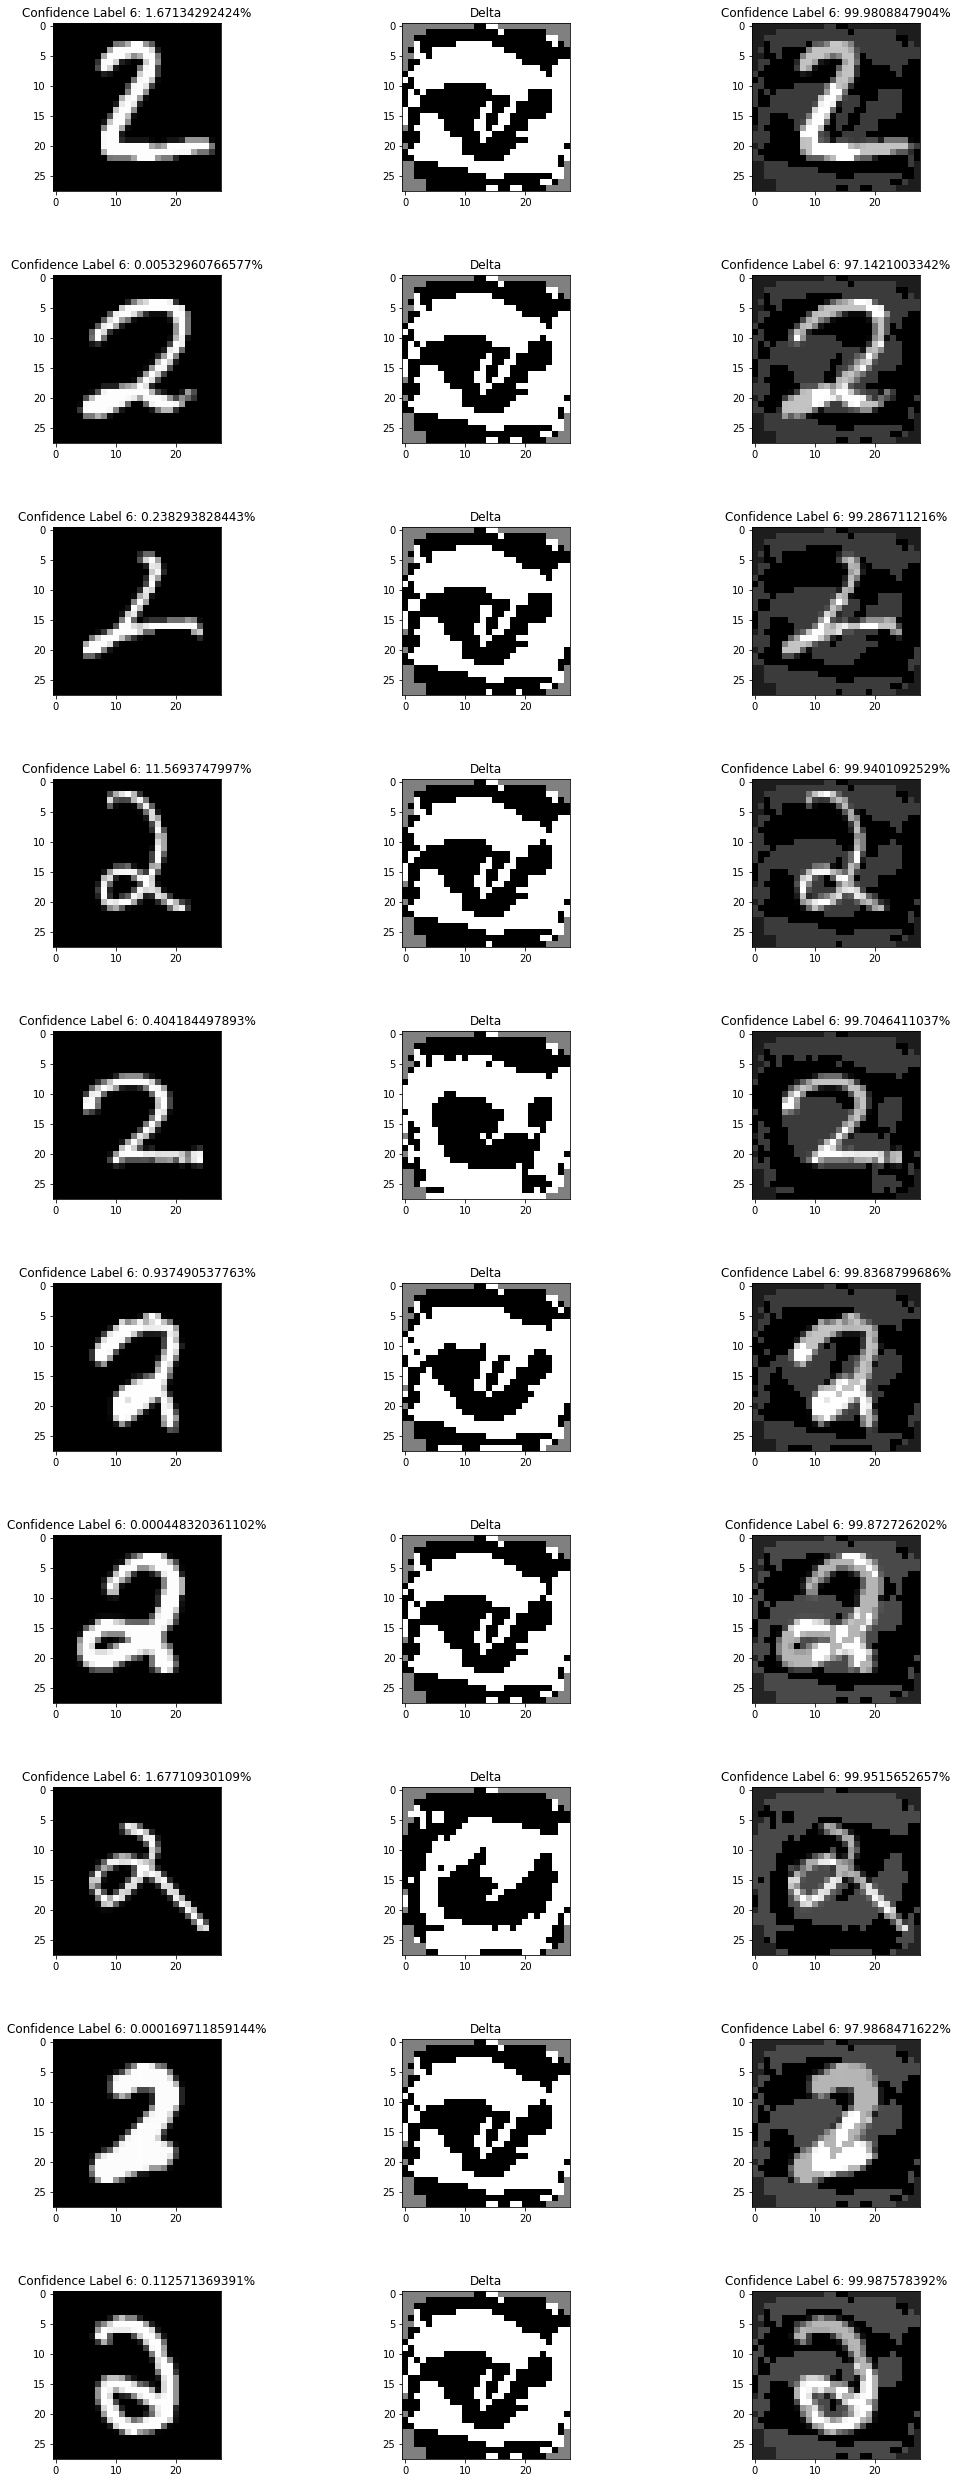

In [12]:
# initialize variable for column index
jump = 3

# initialize number rows
rows = len(original_copy)

# create a figure
plt.figure(figsize=(17, 17))
        
# plot orginal image -> sign of gradient -> adversarial image
for i in range(len(original_copy)):

    # get the model confidence that the original image is a 6
    plt.subplot(rows,3,jump - 2).set_title("Confidence Label 6: " + str(sess.run(pred, feed_dict={x:original_copy[i].reshape((1, 784))})[0][6] * 100) + "%")
    plt.subplots_adjust(top = 2, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.imshow(original_copy[i].reshape(28,28), cmap='gray')

    # plot gradient sign value
    plt.subplot(rows,3,jump - 1).set_title("Delta")
    plt.imshow(sign_values[i].reshape(28,28), cmap='gray')

    # get the model confidence that the adversarial image is a 6
    plt.subplot(rows,3,jump).set_title("Confidence Label 6: " + str(sess.run(pred, feed_dict={x:adversarial[i].reshape((1, 784))})[0][6] * 100) + "%")
    plt.imshow(adversarial[i].reshape(28,28), cmap='gray')
            
    jump = jump + 3
        
plt.show()

In [13]:
# after altering each image, have the model make a prediction on adversarial images
classification_adversarial = sess.run(tf.argmax(pred, 1), feed_dict={x:adversarial})

In [14]:
classification_adversarial

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [15]:
# calculate the probability of each prediction for adversarial images
max_prob = [np.amax(sess.run(pred, feed_dict={x:adversarial[i].reshape((1, 784))})) * 100 for i in range(len(original_copy))]

In [16]:
max_prob

[99.980884790420532,
 97.14210033416748,
 99.2867112159729,
 99.940109252929688,
 99.704641103744507,
 99.836879968643188,
 99.872726202011108,
 99.951565265655518,
 97.986847162246704,
 99.987578392028809]

The model was tricked into thinking that the adversarial images generated were all images of the number 6. The confidence of each prediction is quite good, most are over 99%.

In [17]:
# after altering each image, have the model make a prediction on gradient sign
classification_sign = sess.run(tf.argmax(pred, 1), feed_dict={x:sign_values})

In [18]:
classification_sign

array([2, 2, 2, 2, 7, 2, 2, 9, 2, 2])

In [19]:
# calculate the probability of each prediction for gradient sign values
max_prob = [np.amax(sess.run(pred, feed_dict={x:sign_values[i].reshape((1, 784))})) * 100 for i in range(len(original_copy))]

In [20]:
max_prob

[99.999892711639404,
 99.999904632568359,
 99.999821186065674,
 99.999892711639404,
 100.0,
 99.814009666442871,
 99.999904632568359,
 99.910092353820801,
 99.999904632568359,
 99.999904632568359]

The remaining confidence values are for the predictions of the gradient sign values that are used to generate adversarial images.